# Password Strength Prediction Using NLP

***This notebook contains Modelling and Evaluation of the model.***

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Loading Data from Joblib

In [2]:
X = joblib.load('../Artifacts/X_features.pkl')
y = joblib.load('../Artifacts/y_labels.pkl')
tfidf = joblib.load('../Artifacts/tfidf_vectorizer.pkl')

## Splitting Data Into Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline Model: Logistic Regression

#### Training simple logistic regression model

Explanation of Use of Parameters:

    solver='saga' -> best for high-dimensional sparse data
    n_jobs=-1 -> for using all CPU cores for performance optimization
    multi_class='multinomial' -> since we have three password strength classes

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, verbose=1, multi_class='multinomial')
log_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.14786126
Epoch 3, change: 0.13160076
Epoch 4, change: 0.1279643
Epoch 5, change: 0.12817302
Epoch 6, change: 0.12953741
Epoch 7, change: 0.1197918
Epoch 8, change: 0.10630957
Epoch 9, change: 0.095414588
Epoch 10, change: 0.086559228
Epoch 11, change: 0.079146626
Epoch 12, change: 0.072878812
Epoch 13, change: 0.067487929
Epoch 14, change: 0.062814932
Epoch 15, change: 0.058728341
Epoch 16, change: 0.055113693
Epoch 17, change: 0.051899237
Epoch 18, change: 0.049036315
Epoch 19, change: 0.046441595
Epoch 20, change: 0.044109818
Epoch 21, change: 0.041972048
Epoch 22, change: 0.040031121
Epoch 23, change: 0.038255238
Epoch 24, change: 0.036618859
Epoch 25, change: 0.035102261
Epoch 26, change: 0.033703232
Epoch 27, change: 0.032399188
Epoch 28, change: 0.031192395
Epoch 29, change: 0.030063891
Epoch 30, change: 0.029010784
Epoch 31, change: 0.028015655
Epoch 32, change: 0.027092322
Epoch 33, change: 0.026219888
Epoch 34, change: 0.0253959
Epoch 35, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga', verbose=1)

#### Evaluating the baseline logistic model

In [5]:
from sklearn.metrics import accuracy_score

log_reg_y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, log_reg_y_pred)
print("Baseline Logistic Model Accuracy: ", accuracy)

Baseline Logistic Model Accuracy:  0.98135


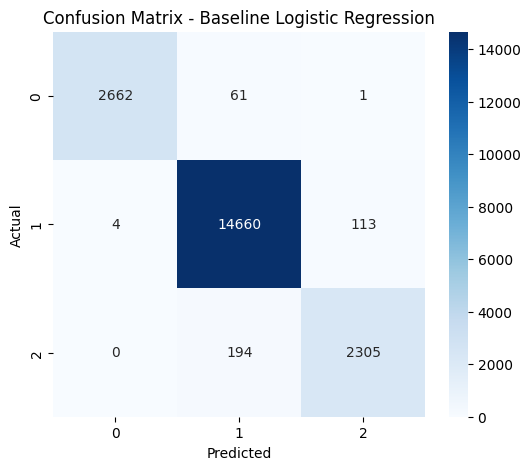

In [6]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, log_reg_y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2724
           1       0.98      0.99      0.99     14777
           2       0.95      0.92      0.94      2499

    accuracy                           0.98     20000
   macro avg       0.98      0.96      0.97     20000
weighted avg       0.98      0.98      0.98     20000



**These results are very strong for a baseline. The model achieved an accuracy of 98.1%, which is extremely high. Looking at the confusion matrix, a weak password is almost never classified as strong. It has very stable middle class and main confusion can be seen in strong vs medium, which is expected. However, this doesn't necessarily seem too good to be true because passwords are very pattern-based and the dataset is large. But it does mean that, since the baseline is already very strong, improvements will be incremental, if any.**

#### Saving the baseline logistic model

In [13]:
joblib.dump(log_reg, '../Models/baseline_logistic.pkl')

['../Models/baseline_logistic.pkl']

## Evaluating the Baseline Against Linear SVM and XGBoost Models

#### Creating an evaluation function for all models

In [14]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    print(f"\n========== {model_name} ==========")
    print("Accuracy:", round(acc, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {"model": model_name, "accuracy": acc}

#### Training the Linear SVM and XGBoost model

In [9]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=1, max_iter=2000)
svm_model.fit(X_train, y_train)

LinearSVC(C=1, max_iter=2000)

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, num_class=3, ...)

#### Calling the evaluation function on two models


========== Linear SVM ==========
Accuracy: 0.9934

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2724
           1       0.99      1.00      1.00     14777
           2       0.99      0.97      0.98      2499

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



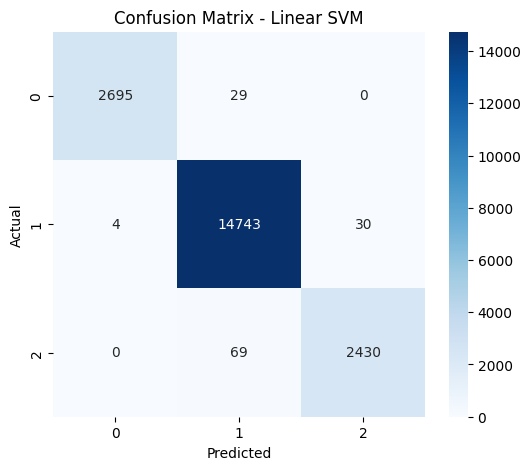


========== XGBoost ==========
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2724
           1       1.00      1.00      1.00     14777
           2       1.00      1.00      1.00      2499

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



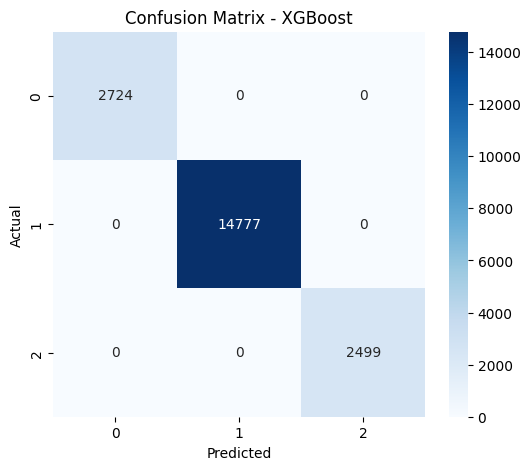

{'model': 'XGBoost', 'accuracy': 1.0}

In [15]:
evaluate_model(svm_model, X_test, y_test, model_name="Linear SVM")
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")